### Imports necesarios

In [18]:
# Useful libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Hyperparameter tuning.
from sklearn.model_selection import GridSearchCV

# Metrics.
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn import metrics

# To prevent some warnings.
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter
simplefilter("ignore", category=ConvergenceWarning)

In [19]:
# Global variables
cutsAmount = 100

### Miscellaneous functions

In [20]:
# Read a cut of the dataset, it assumes that there is going to be four files in the directory,
#   called "xTrain", "xTest", "yTrain", "yTest".
def readCut(dir):
    xTrain = pd.read_csv("{}/xTrain.csv".format(dir), sep=",", error_bad_lines=True, index_col=False, dtype="unicode")
    yTrain = pd.read_csv("{}/yTrain.csv".format(dir), sep=",", error_bad_lines=True, index_col=False, dtype="unicode")
    xTest  = pd.read_csv( "{}/xTest.csv".format(dir), sep=",", error_bad_lines=True, index_col=False, dtype="unicode")
    yTest  = pd.read_csv( "{}/yTest.csv".format(dir), sep=",", error_bad_lines=True, index_col=False, dtype="unicode")

    return xTrain, yTrain, xTest, yTest

# Entries names for the result dictionary.
_accuracy   = "Accuracy"
_precision  = "Precision"
_recall     = "Recall"
_f1         = "F1"
_auc        = "AUC"
_timefit    = "Refit Time"
_model      = "Model"
_min_iter   = "min_cut_iter" 
_max_iter   = "max_cut_iter" 
_model_min  = "model_min"
_model_max  = "model_max"

#Dictionary for visualization ROC
_vis_minMetrics  =   "minMetrics" 
_vis_minModel    =   "minModel" 
_vis_maxMetrics  =   "maxMetrics"
_vis_maxModel    =   "maxModel" 
_vis_pathMin     =   "pathMin"  
_vis_pathMax     =   "pathMax"  

# Metrics array.
_metrics = [_accuracy, _precision, _recall, _f1, _auc, _timefit]

# Names of the feature enginereed datastes.
_normalized   = "Normalized"
_standardized = "Standardized"
_betterFE     = "BetterFE"

# Datasets array.
_datasets = [_normalized, _standardized, _betterFE]

# Entries names for the calculated results.
_min  = "Min"
_max  = "Max"
_mean = "Mean"

# Function to process the results of a model, to get a better print of them.
def processAlgorithmResults(resultDictionary):

    # Result dictionary
    calculatedResultsDictionary = {}
    # Process the results for every feature engineed dataset.
    for dataset in _datasets:
        # Set the current dataset entry.
        calculatedResultsDictionary[dataset] = {}

        # Process every metric.
        for metric in _metrics:
            # Store the metric values.
            metricValues = []
            classifiers = []

            # Process the results for every cut.
            for cut in resultDictionary[dataset]:
                # Get the specific metric value for the current cut.
                metricValues.append(cut[metric])
                classifiers.append(cut[_model])

            # Get the calculated results.
            min_it = np.argmin(metricValues)
            max_it = np.argmax(metricValues)
            calculatedResultsDictionary[dataset][metric] = {
                _min        : min(metricValues),
                _max        : max(metricValues),
                _mean       : sum(metricValues) / len(metricValues),
                _min_iter   : int(min_it + 1),
                _max_iter   : int(max_it + 1),
                _model_min  : classifiers[min_it],
                _model_max  : classifiers[max_it]
            }

    return calculatedResultsDictionary

# Print the calculated results in a tabular form from the calculated results dictionary.
def plotCalculatedResults(calculatedResults):
    # Print the results for every dataset.
    for dataset in _datasets:

        print(dataset, "dataset metrics summary")

        # Create a panda frame to pretty print.
        frame = pd.DataFrame(calculatedResults[dataset])
        
        # Delete models and indices for pretty print
        frame.drop(_model_min, inplace=True)
        frame.drop(_model_max, inplace=True)
        frame.drop(_min_iter, inplace=True)
        frame.drop(_max_iter, inplace=True)

        # Print the frame.
        print(frame)
        print()

# Plot the ROC curve for every dataset, two plots, for the min and max AUC-valued cuts.
def plotROC(calculatedResults, fullDicc):
    # Plot the ROC for every feature engineed dataset.
    for dataset in _datasets:

        print(dataset, "dataset ROC for min and max AUC value")
        
        # Get the model and data for the min AUC-value cut.
        cut_with_min_value  = calculatedResults[dataset][_auc][_min_iter]
        model_min =calculatedResults[dataset][_auc][_model_min]
        pathMin = os.path.join(dataset, "cut" + str(cut_with_min_value))

        # Get the model and data for the max AUC-value cut.
        cut_with_max_value  = calculatedResults[dataset][_auc][_max_iter]
        model_max =calculatedResults[dataset][_auc][_model_max]
        pathMax = os.path.join(dataset, "cut" + str(cut_with_max_value))
        
        # Get all the metrics for the two cuts.
        metric_values_min = {}
        metric_values_max = {}
        for metrics in _metrics:
            metric_values_min[metrics] = fullDicc[dataset][cut_with_min_value - 1][metrics]
            metric_values_max[metrics] = fullDicc[dataset][cut_with_max_value - 1][metrics]

        # Build the result.
        dicc_plot = {
            _vis_minMetrics : metric_values_min,
            _vis_minModel   : model_min,
            _vis_maxMetrics : metric_values_max,
            _vis_maxModel   : model_max,
            _vis_pathMin    : pathMin,
            _vis_pathMax    : pathMax
        }
        
        plotVis(dicc_plot)

# Auxiliary function to plot the ROC.
def plotVis(diccionary):
    print("Min AUC-valued cut")

    # Get the model, path and metrics from the parameter.
    metrics = diccionary[_vis_minMetrics]
    model = diccionary[_vis_minModel]
    path = diccionary[_vis_pathMin]

    # Read the data again.
    xTrain, yTrain, xTest, yTest = readCut(path)

    # Print the metrics.
    print(metrics)
    print(model.best_params_)

    # Plot the ROC.
    plot_roc_curve(model, xTest, yTest)
    plt.show(block = False)
    
    print("Max AUC-valued cut")

    # Get the model, path and metrics from the parameter.
    metrics = diccionary[_vis_maxMetrics]
    model = diccionary[_vis_maxModel]
    path = diccionary[_vis_pathMax]

    # Read the data again.
    xTrain, yTrain, xTest, yTest = readCut(path)

    # Print the metrics.
    print(metrics)
    print(model.best_params_)
    
    # Plot the ROC.
    plot_roc_curve(model, xTest, yTest)
    plt.show(block = False)

# Definition of the models
Each of the following functions is responsible for instantiating the model, defining the parameter grid to find the best parameters, and training the model with the best parameters to make predictions and calculate metrics.

### Logistic Regression

In [21]:
def doLogisticRegression(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    logisticRegression = LogisticRegression()

    # Definition of the parameter grid.
    param_grid = [{'penalty':['l2'],
                'C' : np.logspace(-4, 4, 20),
                'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
                'max_iter':[100, 500],
                'fit_intercept' : [True, False]
    }]
    logreg_cv = GridSearchCV(logisticRegression, param_grid, n_jobs=-1)
    
    # Fit the model.
    logreg_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", logreg_cv.best_params_)

    # Predict using the model.
    yPred = logreg_cv.predict(xTest)
    yProb = logreg_cv.predict_proba(xTest)[:, 1]
   
    # Process the metrics.
    dicResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yPred),
       _precision  : precision_score(yTest.values.ravel(), yPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yPred, pos_label='1'),
       _auc        : roc_auc_score(yTest.values.ravel(), yProb),
       _timefit    : logreg_cv.refit_time_,
       _model      : logreg_cv
    }

    return dicResult


### K-Nearest-Neighbor

In [22]:
def doKNN(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    knn = KNeighborsClassifier()

    # Definition of the parameter grid.
    param_grid = [{'n_neighbors':[i for i in range(3,11)],
                'weights' : ['distance'],
                'algorithm' : ['ball_tree'],
                'leaf_size' : [20],
                'metric' : ['manhattan']
    }]
    knn_cv=GridSearchCV(knn, param_grid, n_jobs=-1)

    # Fit the model.
    knn_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", knn_cv.best_params_)

    # Predict using the model.
    yPred = knn_cv.predict(xTest)
    yProb = knn_cv.predict_proba(xTest)[:, 1]
   
    # Process the metrics.
    dicResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yPred),
       _precision  : precision_score(yTest.values.ravel(), yPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yPred, pos_label='1'),
       _auc        : roc_auc_score(yTest.values.ravel(), yProb),
       _timefit    : knn_cv.refit_time_,
       _model      : knn_cv
    }

    return dicResult

### Decision Tree

In [23]:
def doDecisionTree(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    decisionTree = DecisionTreeClassifier()

    # Definition of the parameter grid.
    param_grid = [{'criterion':['gini', 'entropy'],
                'max_depth': np.arange(3,15).tolist() + [None],
                'splitter' : ['best', 'random'],
                'max_features' : ['sqrt', 'log2', None]
    }]
    decisionTree_cv=GridSearchCV(decisionTree, param_grid, n_jobs=-1)

    # Fit the model.
    decisionTree_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", decisionTree_cv.best_params_)

    # Predict using the model.
    yPred = decisionTree_cv.predict(xTest)
    yProb = decisionTree_cv.predict_proba(xTest)[:, 1]
   
    # Process the metrics.
    dicResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yPred),
       _precision  : precision_score(yTest.values.ravel(), yPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yPred, pos_label='1'),
       _auc        : roc_auc_score(yTest.values.ravel(), yProb),
       _timefit    : decisionTree_cv.refit_time_,
       _model      : decisionTree_cv
    }

    return dicResult

### Neural Network

In [24]:
def doNeuralNetwork(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    nnClassifier = MLPClassifier()
    
    # Definition of the parameter grid.
    # Use Saul's Heuristic for the amount of the hidden layers.
    numberFeatures = xTrain.shape[1]
    hiddenLayerAmount = range(numberFeatures // 2, 2 * numberFeatures + 1, 2)
    param_grid =[{
        'hidden_layer_sizes': [(n,) for n in hiddenLayerAmount],
        'activation': ['tanh', 'relu'],
        'solver': ['adam'],
        'max_iter': [1000, 1500],
        'alpha': [0.0001, 0.05],
    }]
    nnClassifier_cv = GridSearchCV(nnClassifier, param_grid, n_jobs=-1)

    # Fit the model.
    nnClassifier_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", nnClassifier_cv.best_params_)

    # Predict using the model.
    yPred = nnClassifier_cv.predict(xTest)
    yProb = nnClassifier_cv.predict_proba(xTest)[:, 1]

    # Process the metrics.
    dicResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yPred),
       _precision  : precision_score(yTest.values.ravel(), yPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yPred, pos_label='1'),
       _auc        : roc_auc_score(yTest.values.ravel().astype(np.int), yProb),
       _timefit    : nnClassifier_cv.refit_time_,
       _model      : nnClassifier_cv
    }

    return dicResult

# Execution of the models
We are going to run each model for every cut for every feature engineered dataset.

In [25]:
# Function to execute a specified model for each cut of each dataset, save every result
#   and store it in a dictionary results for a later procesation.
def runModel(modelFunction):
    # Dictionary for the logistic regression results.
    modelResults = {
        _normalized : [],
        _standardized : [],
        _betterFE : []
    }

    # Run the algorithm for ...
    # For every feature engineered dataset.
    for i in _datasets:
        print("Start for", i, "dataset")

        # For every cut.
        for j in range(1, cutsAmount + 1):

            print("\tRunning cut {}...".format(j), end=" ")

            # Build the dir.
            path = os.path.join(i, "cut" + str(j))

            # Get the cut from disk.
            xTrain, yTrain, xTest, yTest = readCut(path)

            # Run logistic regression for the curren cut and get the metrics.
            partialResult = modelFunction(xTrain, yTrain, xTest, yTest)
            # Store the metrics for the current feature engineered dataset.
            modelResults[i].append(partialResult)

            print("done!")

    return modelResults

### Logistic regression execution

In [26]:
print("Running Logistic regression...")

# Execute logistic regression for each cut of each dataset and get the results.
logisticRegressionResults = runModel(doLogisticRegression)

# Get the calculated mean, the min and the max for every metric.
logisticRegressionCalculatedResults = processAlgorithmResults(logisticRegressionResults)

Running Logistic regression...
Start for Normalized dataset
	Running cut 1... done!
	Running cut 2... done!
	Running cut 3... done!
	Running cut 4... done!
	Running cut 5... done!
	Running cut 6... done!
	Running cut 7... done!
	Running cut 8... done!
	Running cut 9... done!
	Running cut 10... done!
	Running cut 11... done!
	Running cut 12... done!
	Running cut 13... done!
	Running cut 14... done!
	Running cut 15... done!
	Running cut 16... done!
	Running cut 17... done!
	Running cut 18... done!
	Running cut 19... done!
	Running cut 20... done!
	Running cut 21... done!
	Running cut 22... done!
	Running cut 23... done!
	Running cut 24... done!
	Running cut 25... done!
	Running cut 26... done!
	Running cut 27... done!
	Running cut 28... done!
	Running cut 29... done!
	Running cut 30... done!
	Running cut 31... done!
	Running cut 32... done!
	Running cut 33... done!
	Running cut 34... done!
	Running cut 35... done!
	Running cut 36... done!
	Running cut 37... done!
	Running cut 38... done!

### Logistic regression summary

Normalized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min   0.703125  0.716578  0.684211  0.720721  0.776365  0.00499678
Max    0.79375  0.823899  0.812865  0.804734  0.863024   0.0130007
Mean  0.744219  0.767063  0.749649  0.757855  0.818685  0.00833431

Standardized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min   0.678125  0.686813  0.637427  0.705521  0.756937  0.00499678
Max        0.8  0.828221  0.824561  0.808383  0.871659   0.0150011
Mean  0.741656  0.768053   0.74193  0.754005  0.816164   0.0087097

BetterFE dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min   0.685921  0.703226  0.597315   0.67658  0.761955  0.00399661
Max   0.794224  0.820144  0.838926  0.811881  0.870963  0.00900173
Mean  0.734946  0.762156  0.738859  0.749492   0.81183  0.00695958

Normalized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.7125,

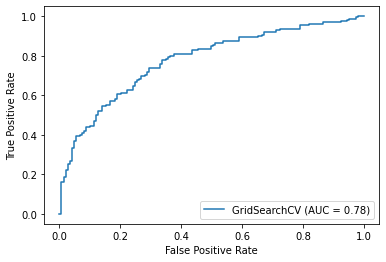

Max AUC-valued cut
{'Accuracy': 0.765625, 'Precision': 0.7758620689655172, 'Recall': 0.7894736842105263, 'F1': 0.7826086956521741, 'AUC': 0.8630244515090858, 'Refit Time': 0.009999990463256836}
{'C': 1.623776739188721, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


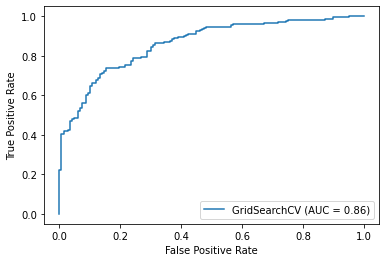

Standardized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.678125, 'Precision': 0.6868131868131868, 'Recall': 0.7309941520467836, 'F1': 0.7082152974504249, 'AUC': 0.7569370854429137, 'Refit Time': 0.005998849868774414}
{'C': 0.03359818286283781, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


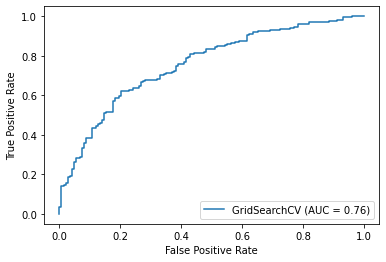

Max AUC-valued cut
{'Accuracy': 0.8, 'Precision': 0.8282208588957055, 'Recall': 0.7894736842105263, 'F1': 0.8083832335329342, 'AUC': 0.8716590133050748, 'Refit Time': 0.010000467300415039}
{'C': 0.615848211066026, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


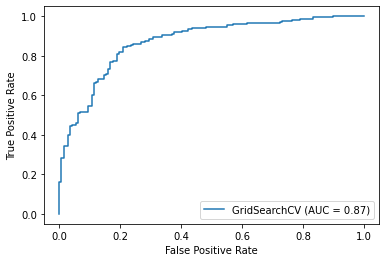

BetterFE dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.7184115523465704, 'Precision': 0.7232704402515723, 'Recall': 0.7718120805369127, 'F1': 0.7467532467532467, 'AUC': 0.7619546979865771, 'Refit Time': 0.007997751235961914}
{'C': 0.08858667904100823, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


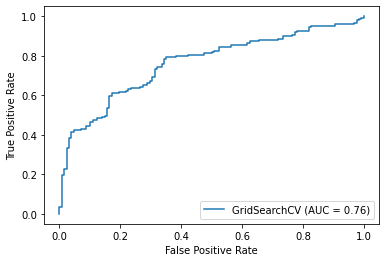

Max AUC-valued cut
{'Accuracy': 0.779783393501805, 'Precision': 0.8055555555555556, 'Recall': 0.7785234899328859, 'F1': 0.7918088737201365, 'AUC': 0.8709626677852349, 'Refit Time': 0.007999658584594727}
{'C': 0.012742749857031334, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


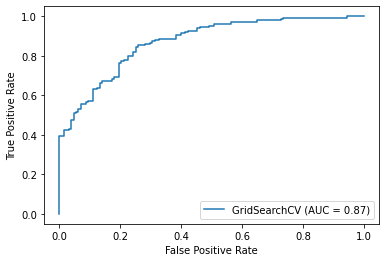

In [27]:
# Print the calculated results in a tabular way
plotCalculatedResults(logisticRegressionCalculatedResults)

# Print the ROC curve for max and min AUC value, with the metrics value.
plotROC(logisticRegressionCalculatedResults, logisticRegressionResults)    

### K-Nearest-Neighbor execution

In [28]:
print("Running K-Nearest-Neighbor...")

# Execute logistic regression for each cut of each dataset and get the results.
KNNResults = runModel(doKNN)

# Get the calculated mean, the min and the max for every metric.
KNNCalculatedResults = processAlgorithmResults(KNNResults)

Running K-Nearest-Neighbor...
Start for Normalized dataset
	Running cut 1... done!
	Running cut 2... done!
	Running cut 3... done!
	Running cut 4... done!
	Running cut 5... done!
	Running cut 6... done!
	Running cut 7... done!
	Running cut 8... done!
	Running cut 9... done!
	Running cut 10... done!
	Running cut 11... done!
	Running cut 12... done!
	Running cut 13... done!
	Running cut 14... done!
	Running cut 15... done!
	Running cut 16... done!
	Running cut 17... done!
	Running cut 18... done!
	Running cut 19... done!
	Running cut 20... done!
	Running cut 21... done!
	Running cut 22... done!
	Running cut 23... done!
	Running cut 24... done!
	Running cut 25... done!
	Running cut 26... done!
	Running cut 27... done!
	Running cut 28... done!
	Running cut 29... done!
	Running cut 30... done!
	Running cut 31... done!
	Running cut 32... done!
	Running cut 33... done!
	Running cut 34... done!
	Running cut 35... done!
	Running cut 36... done!
	Running cut 37... done!
	Running cut 38... done!


### K-Nearest-Neighbor summary

Normalized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min   0.740625   0.73913  0.754386  0.766197   0.83714  0.00499773
Max    0.84375  0.849398  0.906433  0.861111  0.912438  0.00899816
Mean  0.791375  0.790555  0.830351   0.80957  0.877695  0.00561998

Standardized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min     0.7375  0.740741  0.754386  0.758621  0.838279  0.00499916
Max   0.840625   0.83815  0.894737  0.856338  0.922014  0.00700045
Mean  0.795531   0.79194  0.837953  0.814016  0.883801  0.00584972

BetterFE dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min   0.747292  0.736527  0.758389  0.765101  0.836016  0.00399804
Max   0.866426  0.883562  0.919463  0.874576  0.936346  0.00500274
Mean  0.793899  0.793213  0.835839  0.813447   0.88155  0.00440131

Normalized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.74687

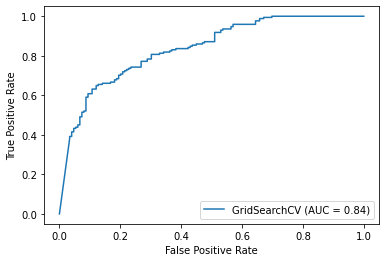

Max AUC-valued cut
{'Accuracy': 0.825, 'Precision': 0.8402366863905325, 'Recall': 0.8304093567251462, 'F1': 0.8352941176470589, 'AUC': 0.9124376937870403, 'Refit Time': 0.005000591278076172}
{'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


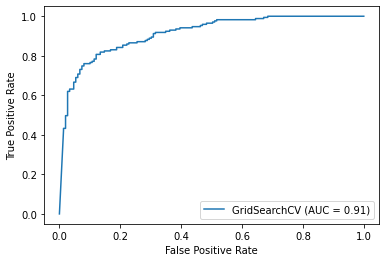

Standardized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.75, 'Precision': 0.7724550898203593, 'Recall': 0.7543859649122807, 'F1': 0.7633136094674557, 'AUC': 0.8382785823619452, 'Refit Time': 0.005999326705932617}
{'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}


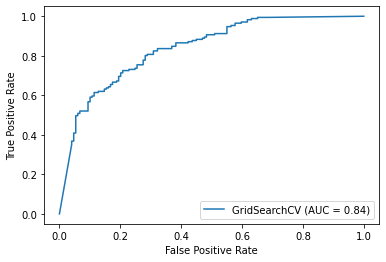

Max AUC-valued cut
{'Accuracy': 0.840625, 'Precision': 0.8260869565217391, 'Recall': 0.8888888888888888, 'F1': 0.8563380281690139, 'AUC': 0.9220142077789552, 'Refit Time': 0.0060002803802490234}
{'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


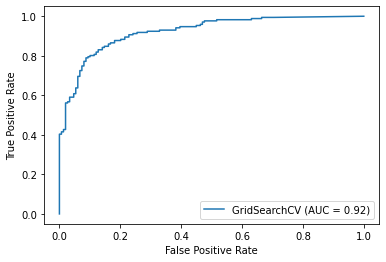

BetterFE dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.7472924187725631, 'Precision': 0.7365269461077845, 'Recall': 0.825503355704698, 'F1': 0.7784810126582278, 'AUC': 0.836016149328859, 'Refit Time': 0.004000425338745117}
{'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}


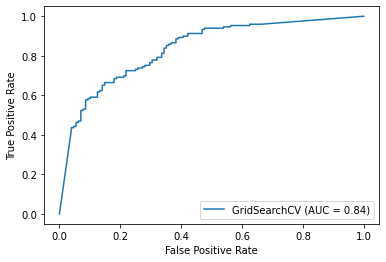

Max AUC-valued cut
{'Accuracy': 0.851985559566787, 'Precision': 0.8417721518987342, 'Recall': 0.8926174496644296, 'F1': 0.8664495114006514, 'AUC': 0.9363464765100671, 'Refit Time': 0.00500178337097168}
{'algorithm': 'ball_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


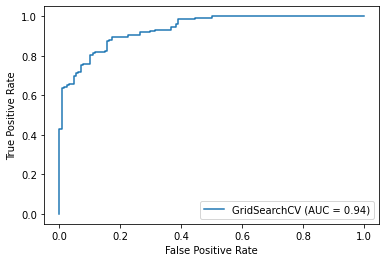

In [29]:
# Print the calculated results in a tabular way
plotCalculatedResults(KNNCalculatedResults)

# Print the ROC curve for max and min AUC value, with the metrics value.
plotROC(KNNCalculatedResults, KNNResults)

### Decision Tree execution

In [30]:
print("Running Decision Tree...")

# Execute logistic regression for each cut of each dataset and get the results.
decisionTreeResults = runModel(doDecisionTree)

# Get the calculated mean, the min and the max for every metric.
decisionTreeCalculatedResults = processAlgorithmResults(decisionTreeResults)

Running Decision Tree...
Start for Normalized dataset
	Running cut 1... done!
	Running cut 2... done!
	Running cut 3... done!
	Running cut 4... done!
	Running cut 5... done!
	Running cut 6... done!
	Running cut 7... done!
	Running cut 8... done!
	Running cut 9... done!
	Running cut 10... done!
	Running cut 11... done!
	Running cut 12... done!
	Running cut 13... done!
	Running cut 14... done!
	Running cut 15... done!
	Running cut 16... done!
	Running cut 17... done!
	Running cut 18... done!
	Running cut 19... done!
	Running cut 20... done!
	Running cut 21... done!
	Running cut 22... done!
	Running cut 23... done!
	Running cut 24... done!
	Running cut 25... done!
	Running cut 26... done!
	Running cut 27... done!
	Running cut 28... done!
	Running cut 29... done!
	Running cut 30... done!
	Running cut 31... done!
	Running cut 32... done!
	Running cut 33... done!
	Running cut 34... done!
	Running cut 35... done!
	Running cut 36... done!
	Running cut 37... done!
	Running cut 38... done!
	Runn

### Decision Tree summary

Normalized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min    0.66875  0.689474  0.684211  0.690058  0.667177  0.00499678
Max    0.78125  0.823529  0.847953       0.8  0.807155   0.0110016
Mean  0.744938  0.760702  0.764035  0.761856  0.754066  0.00729922

Standardized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min        0.7  0.702703  0.666667  0.721893  0.704933  0.00499749
Max    0.80625  0.824242  0.853801  0.823864  0.843263   0.0110009
Mean  0.747281  0.762877  0.766433  0.764063  0.755519  0.00742925

BetterFE dataset metrics summary
      Accuracy Precision    Recall        F1       AUC  Refit Time
Min    0.66426  0.681818   0.66443  0.684746  0.660943  0.00399756
Max   0.801444  0.837209  0.879195  0.820847  0.823983  0.00900006
Mean  0.739892  0.760265  0.756779   0.75771  0.749843  0.00546908

Normalized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.66875

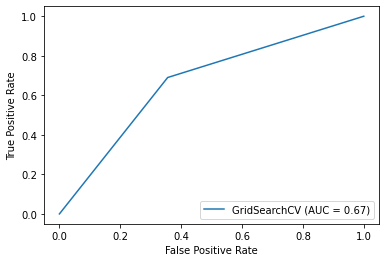

Max AUC-valued cut
{'Accuracy': 0.753125, 'Precision': 0.764367816091954, 'Recall': 0.7777777777777778, 'F1': 0.7710144927536232, 'AUC': 0.8071549118882216, 'Refit Time': 0.008999109268188477}
{'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'splitter': 'best'}


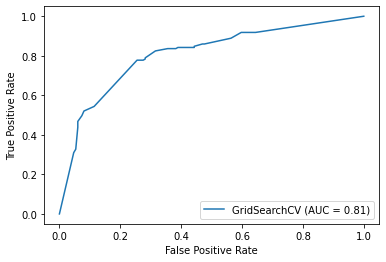

Standardized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.709375, 'Precision': 0.7378048780487805, 'Recall': 0.7076023391812866, 'F1': 0.7223880597014926, 'AUC': 0.7049334746261626, 'Refit Time': 0.006999015808105469}
{'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'splitter': 'best'}


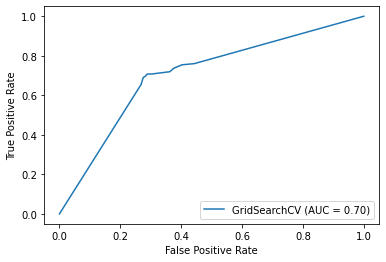

Max AUC-valued cut
{'Accuracy': 0.790625, 'Precision': 0.8095238095238095, 'Recall': 0.7953216374269005, 'F1': 0.8023598820058997, 'AUC': 0.8432630793987206, 'Refit Time': 0.005998849868774414}
{'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'splitter': 'best'}


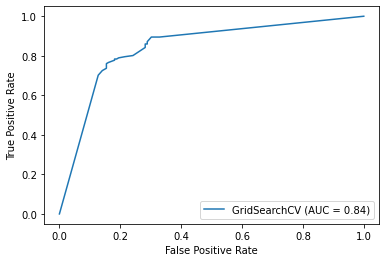

BetterFE dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.6642599277978339, 'Precision': 0.6818181818181818, 'Recall': 0.7046979865771812, 'F1': 0.6930693069306931, 'AUC': 0.6609427432885906, 'Refit Time': 0.0040013790130615234}
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'splitter': 'random'}


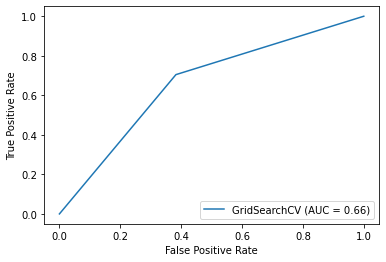

Max AUC-valued cut
{'Accuracy': 0.7725631768953068, 'Precision': 0.8257575757575758, 'Recall': 0.7315436241610739, 'F1': 0.7758007117437723, 'AUC': 0.8239828020134228, 'Refit Time': 0.004998922348022461}
{'criterion': 'entropy', 'max_depth': 13, 'max_features': 'sqrt', 'splitter': 'best'}


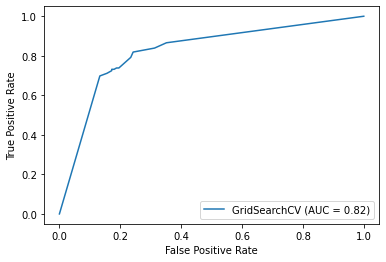

In [31]:
# Print the calculated results in a tabular way
plotCalculatedResults(decisionTreeCalculatedResults)

# Print the ROC curve for max and min AUC value, with the metrics value.
plotROC(decisionTreeCalculatedResults, decisionTreeResults) 

### Neural Network execution

In [32]:
print("Running Neural Network...")

# Execute logistic regression for each cut of each dataset and get the results.
neuralNetworkResults = runModel(doNeuralNetwork)

# Get the calculated mean, the min and the max for every metric.
neuralNetworkCalculatedResults = processAlgorithmResults(neuralNetworkResults)

Running Neural Network...
Start for Normalized dataset
	Running cut 1... done!
	Running cut 2... done!
	Running cut 3... done!
	Running cut 4... done!
	Running cut 5... done!
	Running cut 6... done!
	Running cut 7... done!
	Running cut 8... done!
	Running cut 9... done!
	Running cut 10... done!
	Running cut 11... done!
	Running cut 12... done!
	Running cut 13... done!
	Running cut 14... done!
	Running cut 15... done!
	Running cut 16... done!
	Running cut 17... done!
	Running cut 18... done!
	Running cut 19... done!
	Running cut 20... done!
	Running cut 21... done!
	Running cut 22... done!
	Running cut 23... done!
	Running cut 24... done!
	Running cut 25... done!
	Running cut 26... done!
	Running cut 27... done!
	Running cut 28... done!
	Running cut 29... done!
	Running cut 30... done!
	Running cut 31... done!
	Running cut 32... done!
	Running cut 33... done!
	Running cut 34... done!
	Running cut 35... done!
	Running cut 36... done!
	Running cut 37... done!
	Running cut 38... done!
	Run

### Neural Network summary

Normalized dataset metrics summary
     Accuracy Precision    Recall        F1       AUC Refit Time
Min       0.7  0.708108  0.684211  0.711246  0.782762   0.255997
Max   0.81875  0.830409  0.842105  0.830409  0.868166      1.888
Mean   0.7485  0.771257  0.753333  0.761763  0.823021   0.730589

Standardized dataset metrics summary
      Accuracy Precision    Recall        F1       AUC Refit Time
Min   0.703125  0.715847  0.672515  0.718101  0.789631   0.531001
Max    0.80625  0.831169  0.847953  0.822857  0.879626      3.343
Mean  0.755156  0.774235  0.765789  0.769534  0.830292    2.01622

BetterFE dataset metrics summary
      Accuracy Precision    Recall        F1       AUC Refit Time
Min   0.685921  0.715278  0.630872  0.691176  0.769033   0.375998
Max   0.790614  0.839286  0.838926  0.811688  0.871854      2.689
Mean  0.741552  0.770882  0.740738  0.754732  0.820161    1.25389

Normalized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.703125, 'Precision': 

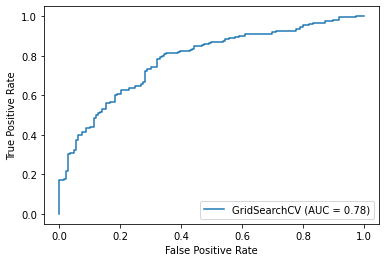

Max AUC-valued cut
{'Accuracy': 0.81875, 'Precision': 0.8304093567251462, 'Recall': 0.8304093567251462, 'F1': 0.8304093567251462, 'AUC': 0.8681659405785157, 'Refit Time': 1.1110000610351562}
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (21,), 'max_iter': 1500, 'solver': 'adam'}


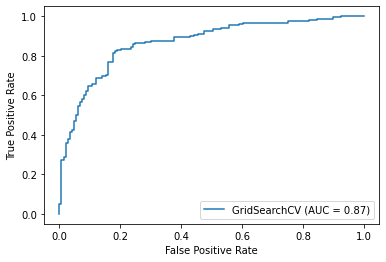

Standardized dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.715625, 'Precision': 0.7298850574712644, 'Recall': 0.7426900584795322, 'F1': 0.7362318840579711, 'AUC': 0.7896306762431806, 'Refit Time': 3.3429994583129883}
{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (21,), 'max_iter': 1500, 'solver': 'adam'}


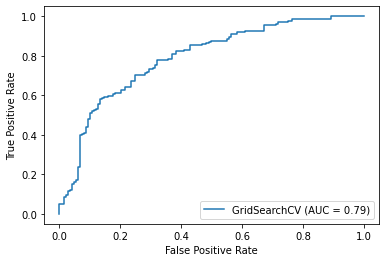

Max AUC-valued cut
{'Accuracy': 0.796875, 'Precision': 0.8081395348837209, 'Recall': 0.8128654970760234, 'F1': 0.8104956268221574, 'AUC': 0.8796263589622826, 'Refit Time': 2.3780009746551514}
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (21,), 'max_iter': 1000, 'solver': 'adam'}


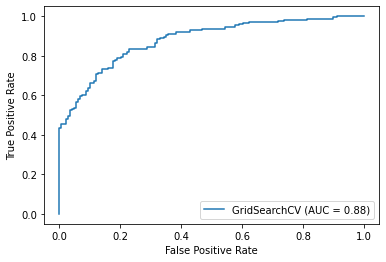

BetterFE dataset ROC for min and max AUC value
Min AUC-valued cut
{'Accuracy': 0.7184115523465704, 'Precision': 0.7669172932330827, 'Recall': 0.6845637583892618, 'F1': 0.7234042553191489, 'AUC': 0.7690331375838926, 'Refit Time': 0.9259991645812988}
{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (14,), 'max_iter': 1000, 'solver': 'adam'}


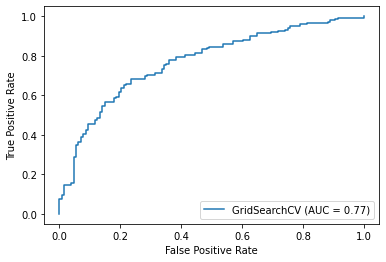

Max AUC-valued cut
{'Accuracy': 0.776173285198556, 'Precision': 0.8, 'Recall': 0.7785234899328859, 'F1': 0.7891156462585034, 'AUC': 0.8718540268456375, 'Refit Time': 1.4539964199066162}
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'max_iter': 1000, 'solver': 'adam'}


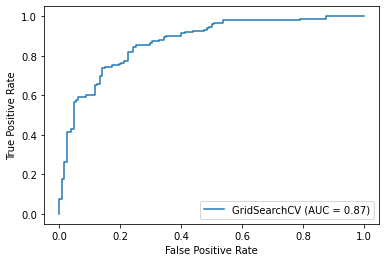

In [33]:
# Print the calculated results in a tabular way
plotCalculatedResults(neuralNetworkCalculatedResults)

# Print the ROC curve for max and min AUC value, with the metrics value.
plotROC(neuralNetworkCalculatedResults, neuralNetworkResults) 

In [34]:
print("Done!")

Done!
